# Проект: Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

### Исходные данные

Данные геологоразведки трёх регионов находятся в файлах:    
`/datasets/geo_data_0.csv`.     
`/datasets/geo_data_1.csv`.    
`/datasets/geo_data_2.csv`.    
* `id` — уникальный идентификатор скважины;
* `f0`, `f1`, `f2` — три признака точек (неважно, что они означают, но сами признаки значимы);
* `product` — объём запасов в скважине (тыс. баррелей).

### Импорты модулей и общие функции

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import RandomState
import pandas as pd
from scipy import stats as st
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

<div style="border:solid purple 5px; padding: 20px">
<h2 align="center"> Рубрика «Питонячий лайфхакер» <a class="tocSkip"> </h2>
    
<h3> Широкоформатный Jupyter <a class="tocSkip"> </h3>
    
Расширяем границы, или как сделать работу более комфортной (не всем нравится 😄)

    from IPython.core.display import display, HTML
    display(HTML("<style>.container { width:90% !important; }</style>"))


In [2]:
def view_and_get_data(path, sep=None, decimal=","):
    """
    Открывает файл, выводит первые 10 строк,
    основную информцию о дата фрейме и возвращает датафрейм.
    Принимает разделить в csv файле и разделитель десятичных чисел(по умолчанию запятая).
    """
    try:
        # Пробуем открыть файл локально, если нет, то через сервер яндекса.
        data = pd.read_csv(path, sep=sep, decimal=decimal, engine='python')
    except Exception:
        print('Локальный файл не найден. Пробую открыть серверную версию файла.')
        data = pd.read_csv(f'https://нельзя_делиться_фреймом{path}', sep=sep, decimal=decimal)
        
    display(data.head(10))
    data.info()
    return data


def hist_and_box_numeric_old(data):
    """
    Принимает датафрейм для построения гистрограм и боксплотов для
    числовых столбцев.
    """
    columns = data.select_dtypes(exclude=['object']).columns.to_list()
    fig, axes = plt.subplots(nrows=len(columns), ncols=2, figsize=(10, 20))
    
    for number in range(len(columns)):
        data[columns[number]].plot(
            ax=axes[number, 0], kind="hist", ylabel=columns[number], rot=0);
        axes[number, 0].set_title(f'Гистограмма {columns[number]}')
        axes[number, 0].set_ylabel('Количество')
        axes[number, 0].set_xlabel('Значения признака')
        data[columns[number]].plot(
            ax=axes[number, 1], kind="box", ylabel='Разброс показателя', rot=0);
        axes[number, 1].set_title(f'Ящик с усами {columns[number]}')
    fig.tight_layout()

def hist_and_box_numeric(data):
    """
    Принимает датафрейм для построения гистрограм и боксплотов для
    числовых столбцев.
    """
    columns = data.select_dtypes(exclude=['object']).columns.to_list()
    for_axis = list(zip(columns, range(0, len(columns)*2, 2)))
    fig, axes = plt.subplots(nrows=len(columns)*2, ncols=1, figsize=(10, 40))
    
    for name, number in for_axis:
        data[name].plot(
            ax=axes[number], kind="hist", ylabel=name, rot=0);
        axes[number].set_title(f'Гистограмма {name}')
        axes[number].set_ylabel('Количество')
        axes[number].set_xlabel('Значения признака')
        data[name].plot(
            ax=axes[number+1], kind="box", ylabel='Разброс показателя', rot=0, vert=False);
        axes[number+1].set_title(f'Ящик с усами {name}')
    fig.tight_layout()    

    
def hist_and_box_obj(data):
    """
    Принимает датафрейм для построения гистрограм и боксплотов для
    категориальных столбцев.
    """
    columns = data.select_dtypes(include=['object']).columns

    if len(columns) > 1:
        columns = columns.to_list()
        fig, axes = plt.subplots(nrows=len(columns), ncols=1, figsize=(10, 20))
        for number in range(len(columns)):
            data[columns[number]].value_counts(normalize=True).plot(
                ax=axes[number], kind='bar', xlabel=columns[number], ylabel='Доля', rot=15);
            axes[number].set_title(f'Диаграмма {columns[number]}')
        fig.tight_layout()
    else:
        columns = columns.to_list()
        data[columns[0]].value_counts(normalize=True).plot(
            kind='bar', xlabel=columns[0], ylabel='Доля', rot=15, title=f'Диаграмма {columns[0]}');

def short_describe(data):
    """Сокращенная версия метдоа describe для упроженного анализа признаков."""
    data = data.describe()
    display(data[data.index.isin(['std', '50%', 'min', 'max'])].T)

def share_of_zero_product(data, name_region):
    """Выводит долю точек с нулевым запасом."""
    count_dot = data.query("product == 0")['product'].count()
    share = count_dot / data['product'].count()
    print(f"Доля и количество точек с нулевым запасом для региона {name_region}: {share:.2f}%, {count_dot}")

### Загрузка данных и изучение общей информации

#### Анализ файла первого региона

In [3]:
data_first_region = view_and_get_data('/datasets/geo_data_0.csv')

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
5,wX4Hy,0.969570,0.489775,-0.735383,64.741541
6,tL6pL,0.645075,0.530656,1.780266,49.055285
7,BYPU6,-0.400648,0.808337,-5.624670,72.943292
8,j9Oui,0.643105,-0.551583,2.372141,113.356160
9,OLuZU,2.173381,0.563698,9.441852,127.910945


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Интересно, в данном случае используется текстовый `id`, что может говорить нам о том, что он скорее всего закондирован или содержит слишком большое количество точек для десятичной системы. Во фрейме 100 000 строк, пропусков нет. 4 столбца в численном формате и 1 в текстовом. Вероятно, похожее будет и в других файлах

#### Анализ файла второго региона

In [4]:
data_second_region = view_and_get_data('/datasets/geo_data_1.csv')

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
5,HHckp,-3.327590,-2.205276,3.003647,84.038886
6,h5Ujo,-11.142655,-10.133399,4.002382,110.992147
7,muH9x,4.234715,-0.001354,2.004588,53.906522
8,YiRkx,13.355129,-0.332068,4.998647,134.766305
9,jG6Gi,1.069227,-11.025667,4.997844,137.945408


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


<div class="alert alert-success">
<h2> Комментарий ревьюера ✔️ <a class="tocSkip"> </h2>

Из готового про EDA можно почитать, например, про [pandas_profiling](https://habr.com/ru/company/ruvds/blog/451478/?)


<div class="alert alert-info">
<h2> Комментарий студента: <a class="tocSkip"> </h2>
Тооочно, забыл про него. Кажется проекта 3 назад его советовали. Непременно перепишу для следующих проектов или использую для небольших своих. Спасибо большое!
    

#### Анализ файла третьего региона

In [5]:
data_third_region = view_and_get_data('/datasets/geo_data_2.csv')

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
5,LzZXx,-0.758092,0.710691,2.585887,90.222465
6,WBHRv,-0.574891,0.317727,1.773745,45.641478
7,XO8fn,-1.906649,-2.458350,-0.177097,72.480640
8,ybmQ5,1.776292,-0.279356,3.004156,106.616832
9,OilcN,-1.214452,-0.439314,5.922514,52.954532


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


#### Гистограммы и ящики с усами

In [6]:
columns = data_first_region.drop(['id'], axis=1).select_dtypes(exclude=['object']).columns.to_list()
for_axis = list(zip(columns, range(0, len(columns)*2, 2)))
for_axis

[('f0', 0), ('f1', 2), ('f2', 4), ('product', 6)]

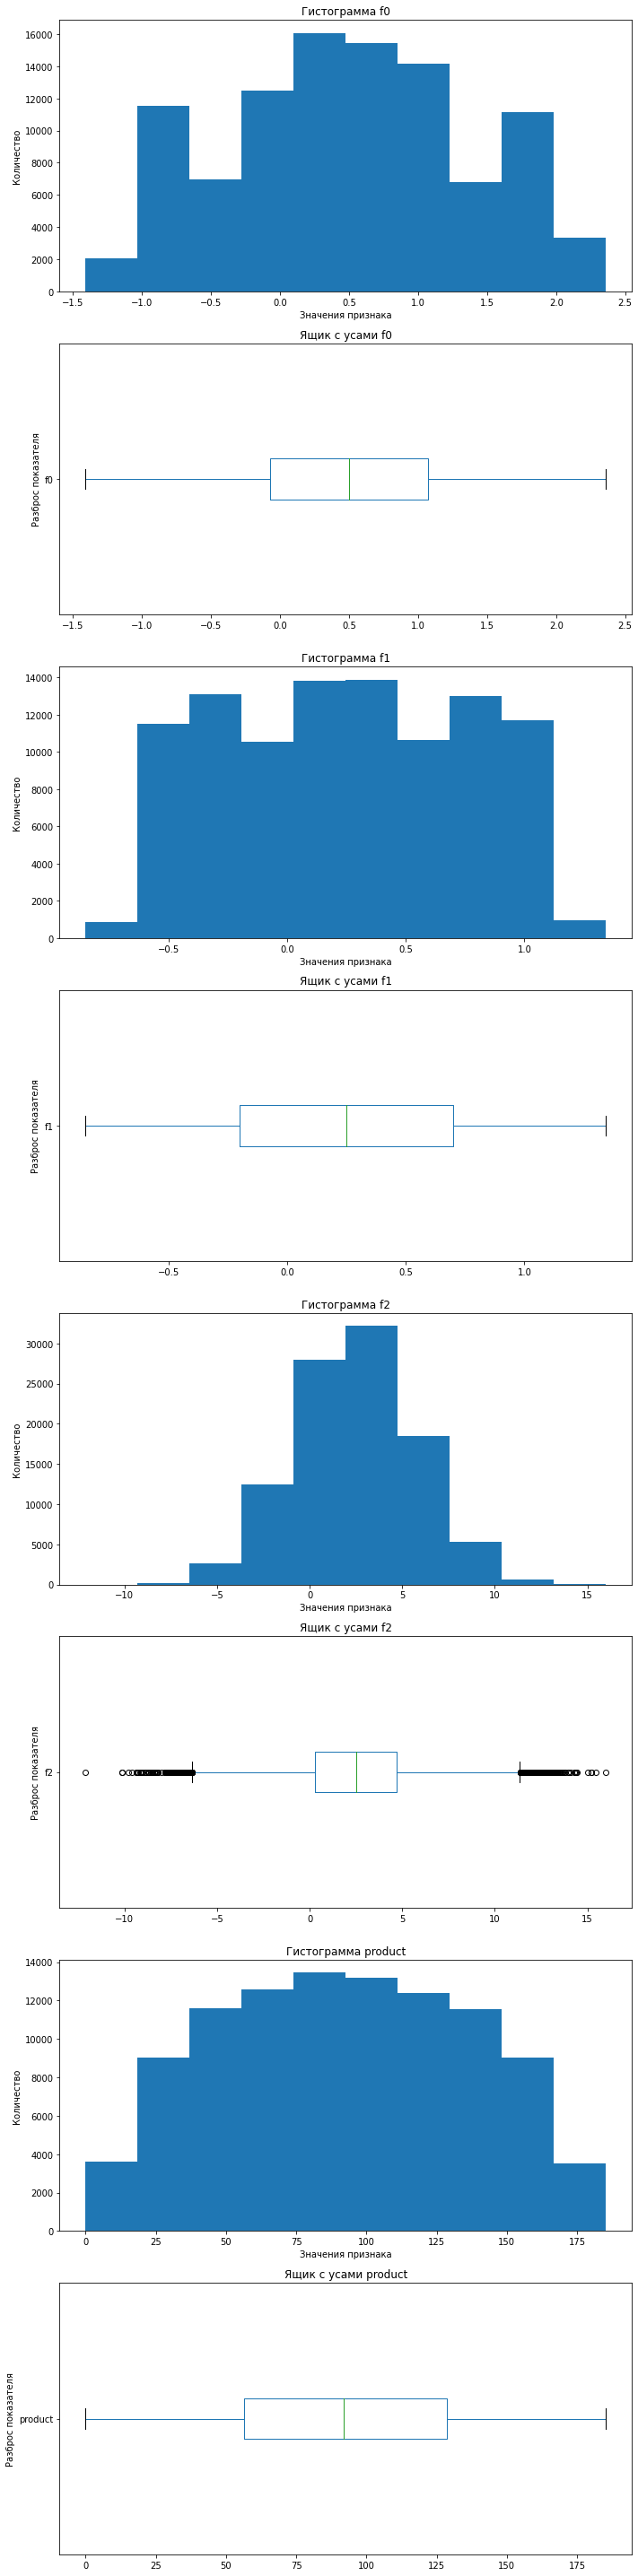

In [7]:
hist_and_box_numeric(data_first_region.drop(['id'], axis=1))

<div class="alert alert-success">
<h2> Комментарий ревьюера ✔️ <a class="tocSkip"> </h2>

Эти два графика (гистограмму распределения и боксплот) я бы расположил друг под другом, при этом удачное решение расположить боксплот горизонтально, тогда графики будут друг под другом, и у них как бы будет единая ось икс
    
</div>

<div class="alert alert-info">
<h2> Комментарий студента: <a class="tocSkip"> </h2>
О, и на самом деле. А то визуально их как бы переворачиваешь. При этом так же будет удобнее и понятнее для анализа. Спасибо! Реализовано.

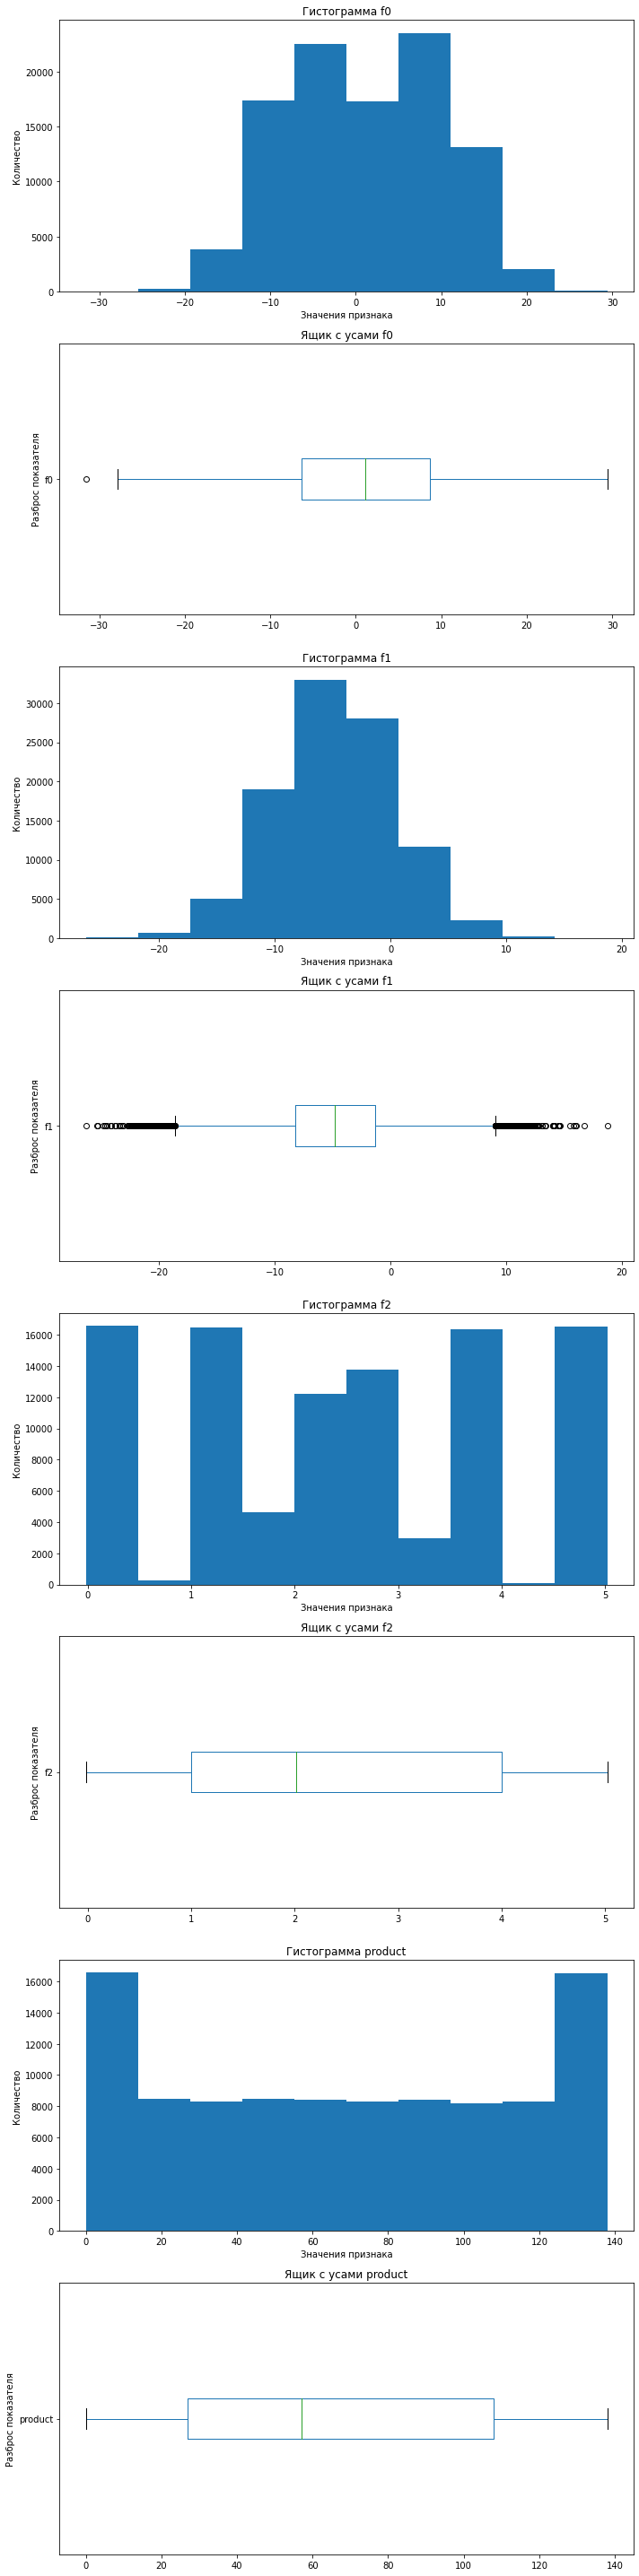

In [8]:
hist_and_box_numeric(data_second_region.drop(['id'], axis=1))

<div class="alert alert-success">
<h2> Комментарий ревьюера ✔️ <a class="tocSkip"> </h2>

Кстати, если тебе поднадоел стандартный `matplotlib`, попробуй пострить графики с помощью [plotly](https://plotly.github.io/plotly.py-docs/generated/plotly.express.histogram.html)

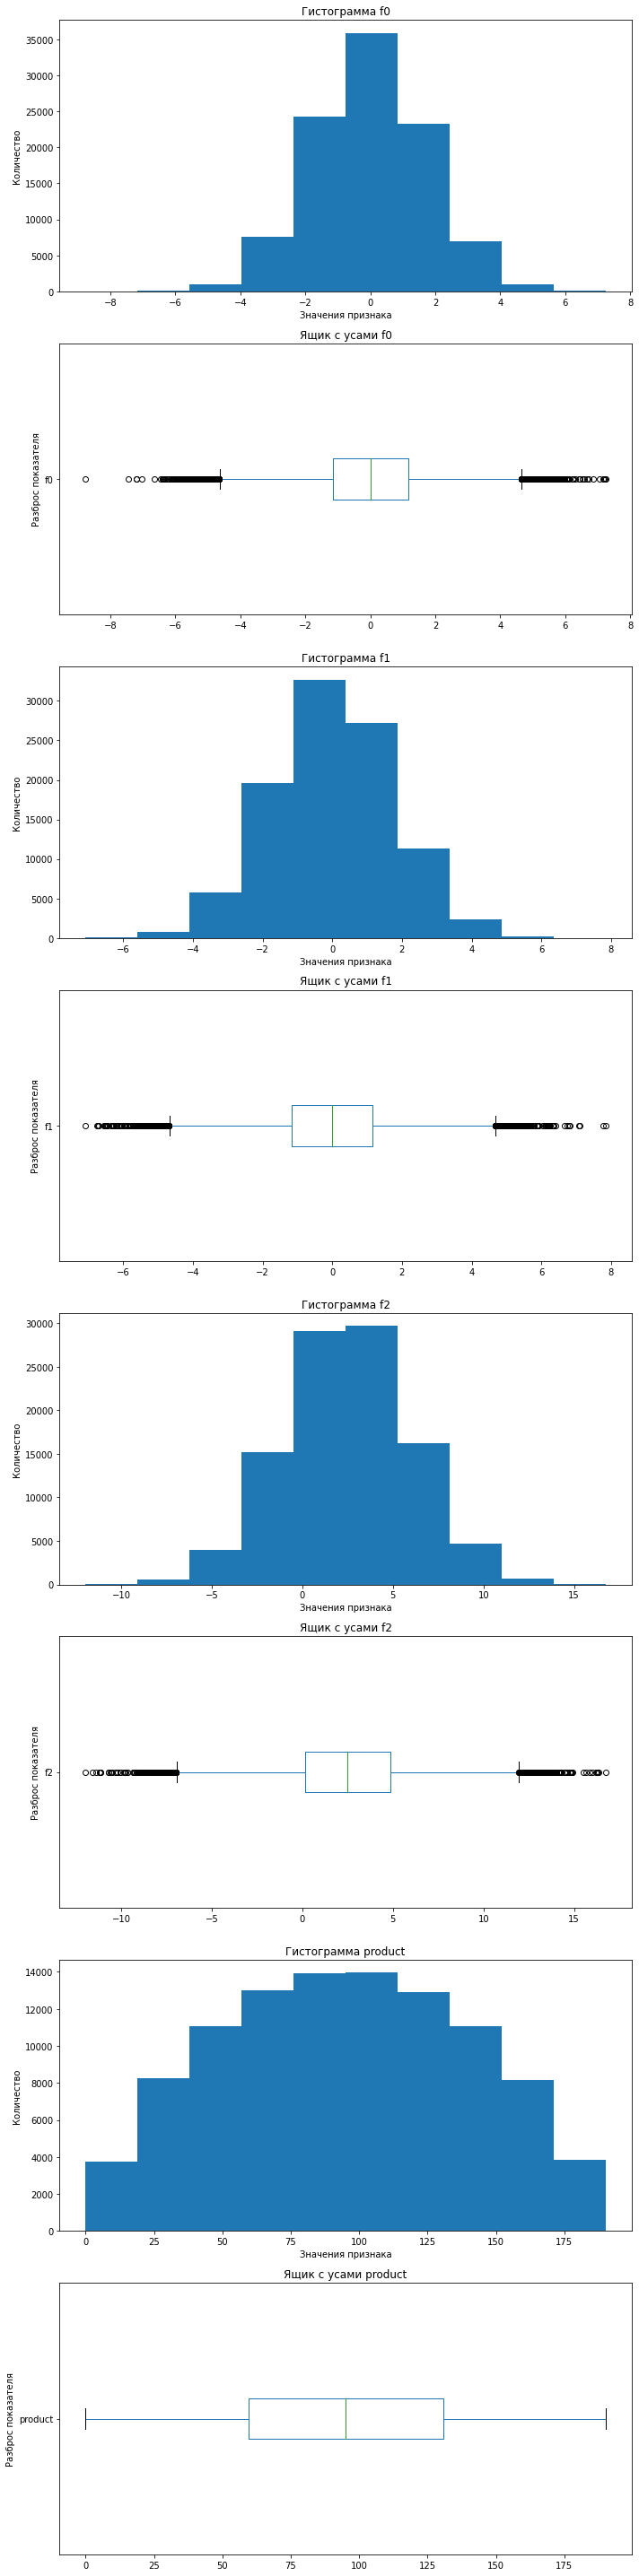

In [9]:
hist_and_box_numeric(data_third_region.drop(['id'], axis=1))

Поскольку про три признака мы знаем лишь о их важности, поэтому сложно сказать что-то конкретное, но явных значтельных выбросов нет, для второго региона один из признаков мог бы стать категориальным по необходимости. Для двух других регионов распределение этих признаков, в целом, равномерное. А вот касательно целевого признака объема запасов в скважине, то второй регион смотрится очень странно. Логично предположить, что распределение нефти должно быть более-менее равномерным, но для второго региона есть два пика в самом начале значений и конце и практически одинаковое распределение для других точек. Интереснее всего по медианному значению рассматривать третий и первый регион, затем уже второй, но это лишь предвариательный вывод, который можно уже будет проверить далее.

#### Предобработка данных

В предыдущем разделе мы видим, что явных аномалий нет, пропущенных значений нет, поэтому может посмотреть на распределение данных более детально.

In [10]:
short_describe(data_first_region.drop(['id'], axis=1))

,std,min,50%,max
f0,0.871832,-1.408605,0.502360,2.362331
f1,0.504433,-0.848218,0.250252,1.343769
f2,3.248248,-12.088328,2.515969,16.003790
product,44.288691,0.000000,91.849972,185.364347


In [11]:
short_describe(data_second_region.drop(['id'], axis=1))

,std,min,50%,max
f0,8.965932,-31.609576,1.153055,29.421755
f1,5.119872,-26.358598,-4.813172,18.734063
f2,1.703572,-0.018144,2.011479,5.019721
product,45.944423,0.000000,57.085625,137.945408


In [12]:
short_describe(data_third_region.drop(['id'], axis=1))

,std,min,50%,max
f0,1.732045,-8.760004,0.009424,7.238262
f1,1.730417,-7.084020,-0.009482,7.844801
f2,3.473445,-11.970335,2.484236,16.739402
product,44.749921,0.000000,94.925613,190.029838


Среднее отклонение объема запасов примерно одинаково для трех регионов, но вот точки с нулевым запасом мне кажутся излишними. По заданию нам не нужно предсказывать убыточные точки в регионах, а наборот те, где количество запасов максимально. Проверим долю точек от общего количество, где запасы равны нулю.

In [13]:
share_of_zero_product(data_first_region, 1)

Доля и количество точек с нулевым запасом для региона 1: 0.00%, 1


In [14]:
share_of_zero_product(data_second_region, 2)

Доля и количество точек с нулевым запасом для региона 2: 0.08%, 8235


In [15]:
share_of_zero_product(data_third_region, 3)

Доля и количество точек с нулевым запасом для региона 3: 0.00%, 1


Таких данных очень мало во фреймах, чтобы они оказали значительное влияние на результаты работы модели. Поэтому смело их удаляем за ненадобностью.

data_first_region = data_first_region.query("product != 0")
data_second_region = data_second_region.query("product != 0")
data_third_region = data_third_region.query("product != 0")

Скорее всего после ревью мне придет замечание, что удалять признаки не нужно. Что ж, к чему это привело?..Риск для второго региона составил порядка 0%, сейчас он около 1,5%. По логике скорее всего нет необходимости удалять нулевые значения, ведь их мало и они не повлияют на общий фрейм, но провести мини эксперимент было интересно.

<div class="alert alert-success">
<h2> Комментарий ревьюера ✔️ <a class="tocSkip"> </h2>


![](https://i.gifer.com/R0YH.gif)

</div>

#### Исследовательский анализ данных

In [16]:
def research_numeric_data(data, value):
    """Выводим описание столбца числового типа, гистограмму с этим столбцом."""
    print('Описание данных:')
    display(data[value].describe().T)
    print()
    print('Уникальные значения(10 наиболее частых):')
    display(data[value].value_counts(ascending=False).head(10))
    print()
    fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15, 5))

    data[value].plot(
        ax=axes[0], kind="hist", rot=0);
    axes[0].set_title(f"Гистограмма {value}")
    axes[0].set_ylabel('Количество')
    axes[0].set_xlabel(f'Значения признака {value}')
    data[value].plot(
        ax=axes[1], kind="box", xlabel=value, rot=0);
    axes[1].set_title(f'Ящик с усами {value}')
    fig.tight_layout()

def scatter_plot(data, x, y, objects):
    """Строит диаграммы рассеяния по переданным признакам в зависимости от списка категориальных."""
    row = 0
    column = 0
    fig, axes = plt.subplots(nrows=(len(objects) % 3), ncols=3, figsize=(20, 15))
    for obj in objects:
        sns.scatterplot(data=data, x=x, y=y, hue=obj, palette="husl", ax=axes[row, column])
        column += 1
        if column == 3:
            column = 0
            row += 1
    plt.show()

def research_numeric_data_with_target(data, value, target):
    """
    Распределение числового признака в зависимости от целевого.
    Наложенные диаграммы и два боксплота.
    """
    fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(15, 5))
    
    unique_target = data[target].unique()
    
    data[data[target] == unique_target[0]][value].plot(
        ax=axes[0], kind="hist", rot=0, color="r", label=unique_target[0], alpha=0.5)
    data[data[target] == unique_target[1]][value].plot(
        ax=axes[0], kind="hist", rot=0, color="g", label=unique_target[1], alpha=0.5)
    axes[0].set_title('Гистограммы с целевым признаком')
    axes[0].set_ylabel('Количество')
    axes[0].legend()
    axes[0].set_xlabel(f'Значения признака {value}')
    
    data[data[target] == unique_target[0]][value].plot(
        ax=axes[1], kind="box", xlabel=value, rot=0);
    axes[1].set_title(f'Боксплот с целевым признаком {unique_target[0]}')
    
    data[data[target] == unique_target[1]][value].plot(
        ax=axes[2], kind="box", xlabel=value, rot=0);
    axes[2].set_title(f'Боксплот с целевым признаком {unique_target[1]}')
    fig.tight_layout()


Для удобства анализа неизвестных нам признаков, переведем запасы в категориальный признак. Будем рассматривать его относительно больше 90 и меньше 90.

In [17]:
analys_first_region = data_first_region.copy()
analys_second_region = data_second_region.copy()
analys_third_region = data_third_region.copy()
analys_first_region['category_product'] = analys_first_region['product'].apply(
    lambda x: 'более 90' if x >= 90 else 'менее 90')
analys_second_region['category_product'] = analys_second_region['product'].apply(
    lambda x: 'более 90' if x >= 90 else 'менее 90')
analys_third_region['category_product'] = analys_third_region['product'].apply(
    lambda x: 'более 90' if x >= 90 else 'менее 90')

Описание данных:


count    100000.000000
mean          0.500419
std           0.871832
min          -1.408605
25%          -0.072580
50%           0.502360
75%           1.073581
max           2.362331
Name: f0, dtype: float64


Уникальные значения(10 наиболее частых):


-1.218900    1
 0.407085    1
 1.162604    1
 0.886105    1
 0.031749    1
 1.059636    1
 0.069664    1
-0.292275    1
 1.906720    1
 1.965702    1
Name: f0, dtype: int64

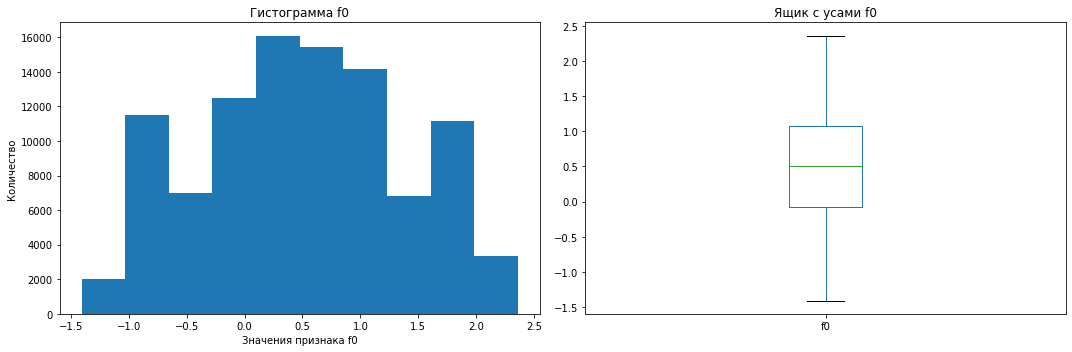

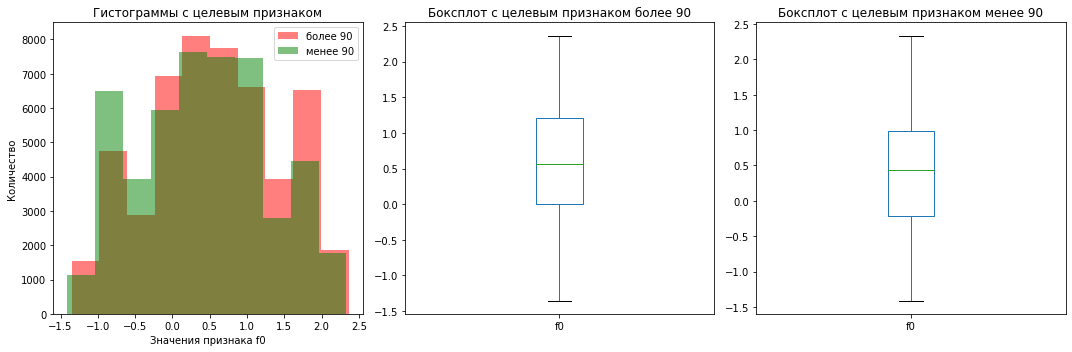

In [18]:
research_numeric_data(analys_first_region, 'f0')
research_numeric_data_with_target(analys_first_region, 'f0', 'category_product')

Описание данных:


count    100000.000000
mean          0.250143
std           0.504433
min          -0.848218
25%          -0.200881
50%           0.250252
75%           0.700646
max           1.343769
Name: f1, dtype: float64


Уникальные значения(10 наиболее частых):


 0.296390    1
-0.360328    1
-0.203243    1
 0.040378    1
 0.860821    1
 0.664362    1
 0.848563    1
 0.717608    1
 0.514980    1
 0.058519    1
Name: f1, dtype: int64

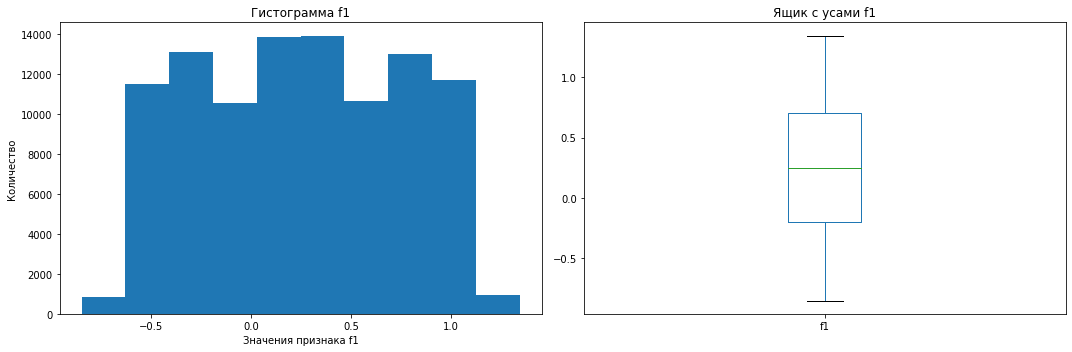

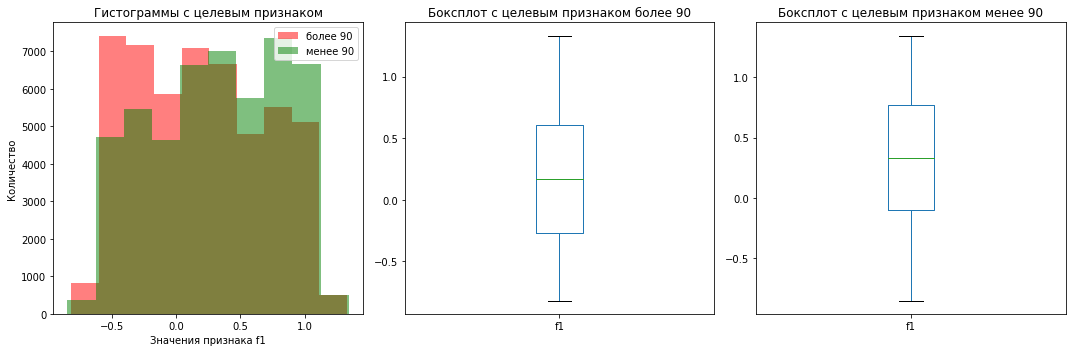

In [19]:
research_numeric_data(analys_first_region, 'f1')
research_numeric_data_with_target(analys_first_region, 'f1', 'category_product')

Описание данных:


count    100000.000000
mean          2.502647
std           3.248248
min         -12.088328
25%           0.287748
50%           2.515969
75%           4.715088
max          16.003790
Name: f2, dtype: float64


Уникальные значения(10 наиболее частых):


 4.623968    1
 0.485455    1
 0.899164    1
 5.973383    1
 4.349341    1
 4.424615    1
-0.575217    1
 5.793415    1
 6.164793    1
 2.429074    1
Name: f2, dtype: int64

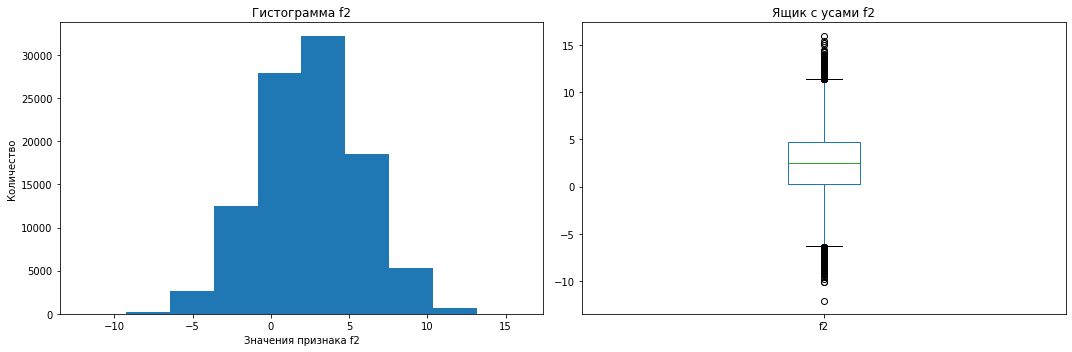

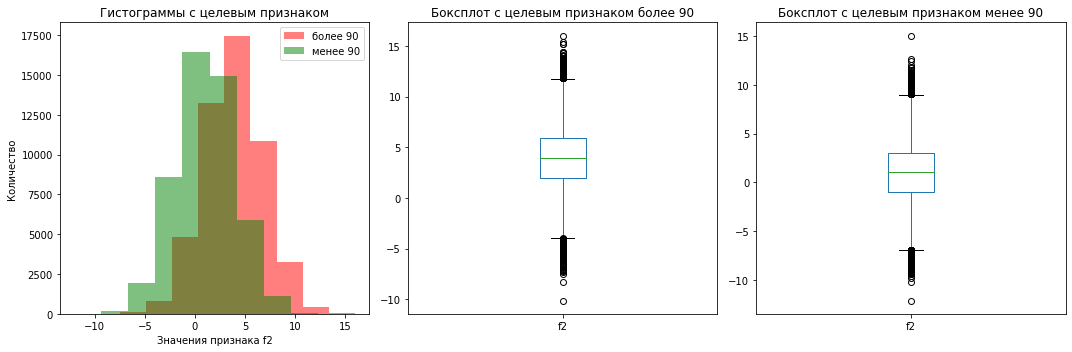

In [20]:
research_numeric_data(analys_first_region, 'f2')
research_numeric_data_with_target(analys_first_region, 'f2', 'category_product')

Сложно анализировать признаки, чье предназначение нам неизвестно, но мы можем вполне опускаться до цифр. В целом, можно заметить по всем трем признакам, что чем они ниже, тем ниже и запасы. Это меньше всего заметно для `f0`, но более явно для `f1` и особенно для `f2`. 

Описание данных:


count    100000.000000
mean          1.141296
std           8.965932
min         -31.609576
25%          -6.298551
50%           1.153055
75%           8.621015
max          29.421755
Name: f0, dtype: float64


Уникальные значения(10 наиболее частых):


 9.471578     1
 17.560369    1
 20.515576    1
 4.648343     1
 8.195679     1
 7.500093     1
 5.116008     1
-4.089223     1
 5.816321     1
 3.177526     1
Name: f0, dtype: int64

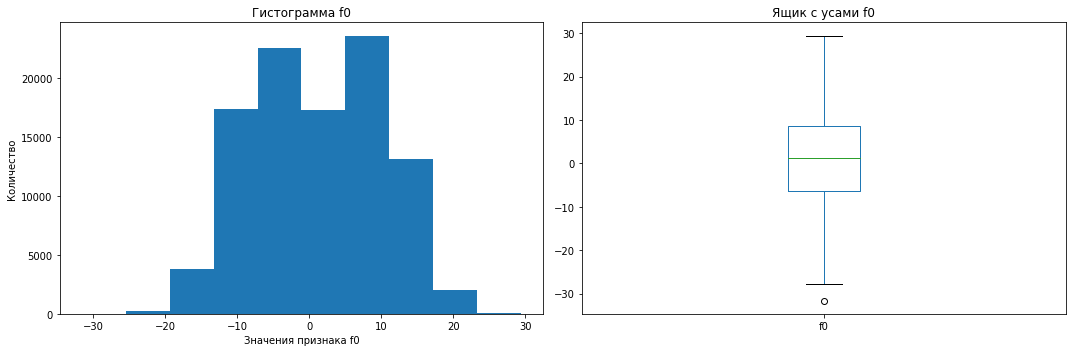

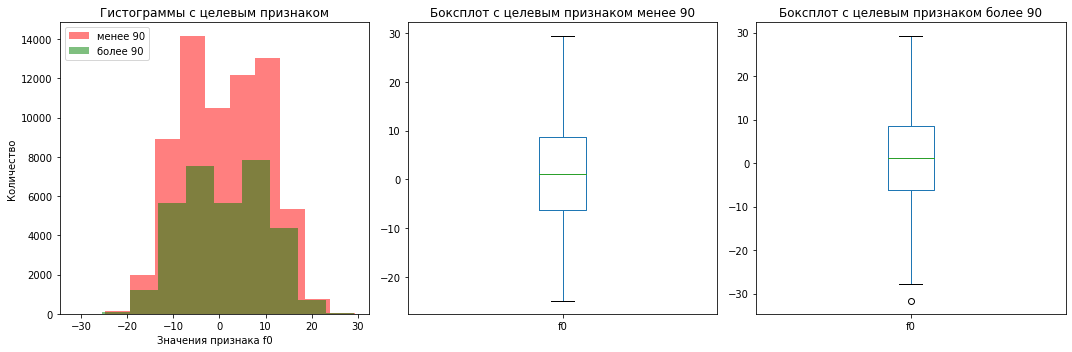

In [21]:
research_numeric_data(analys_second_region, 'f0')
research_numeric_data_with_target(analys_second_region, 'f0', 'category_product')

Описание данных:


count    100000.000000
mean         -4.796579
std           5.119872
min         -26.358598
25%          -8.267985
50%          -4.813172
75%          -1.332816
max          18.734063
Name: f1, dtype: float64


Уникальные значения(10 наиболее частых):


-7.148426    1
-6.241057    1
 0.219865    1
-1.778543    1
-9.636482    1
-0.301129    1
-5.803844    1
-7.463994    1
-6.136815    1
 0.594509    1
Name: f1, dtype: int64

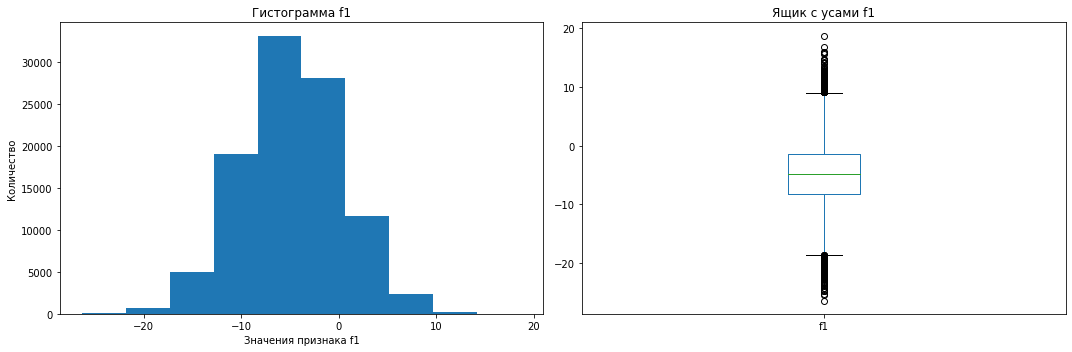

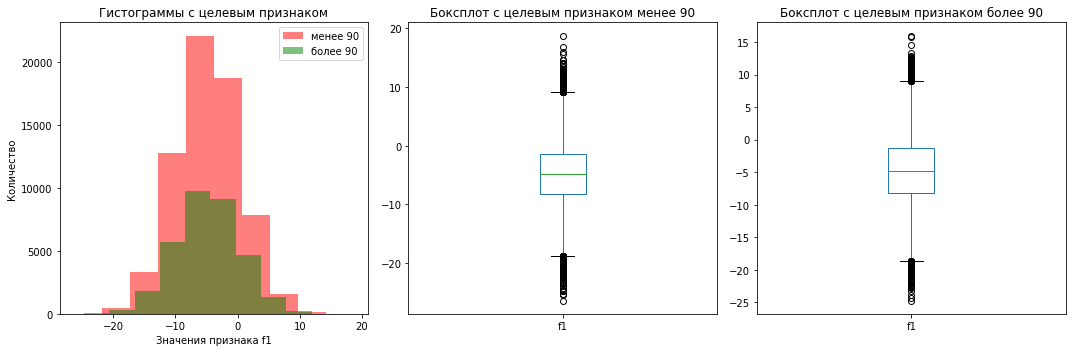

In [22]:
research_numeric_data(analys_second_region, 'f1')
research_numeric_data_with_target(analys_second_region, 'f1', 'category_product')

Описание данных:


count    100000.000000
mean          2.494541
std           1.703572
min          -0.018144
25%           1.000021
50%           2.011479
75%           3.999904
max           5.019721
Name: f2, dtype: float64


Уникальные значения(10 наиболее частых):


 3.996243    1
 4.003988    1
 1.996189    1
 0.996936    1
 3.998589    1
-0.000625    1
 1.999167    1
 5.005170    1
 2.993676    1
 4.992522    1
Name: f2, dtype: int64

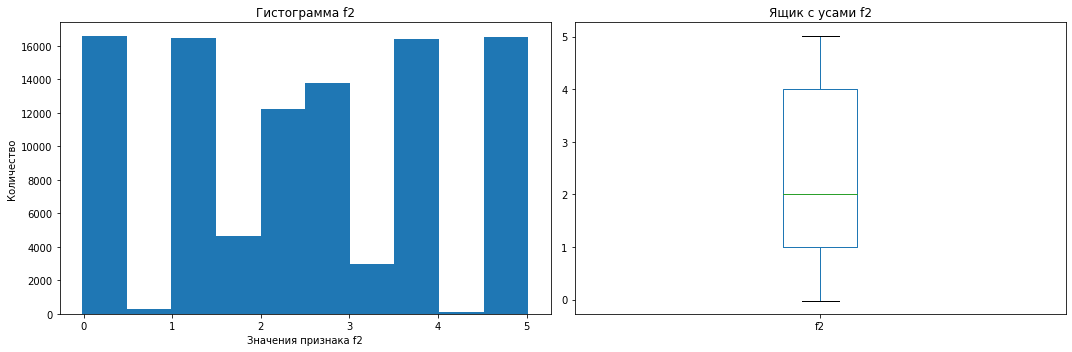

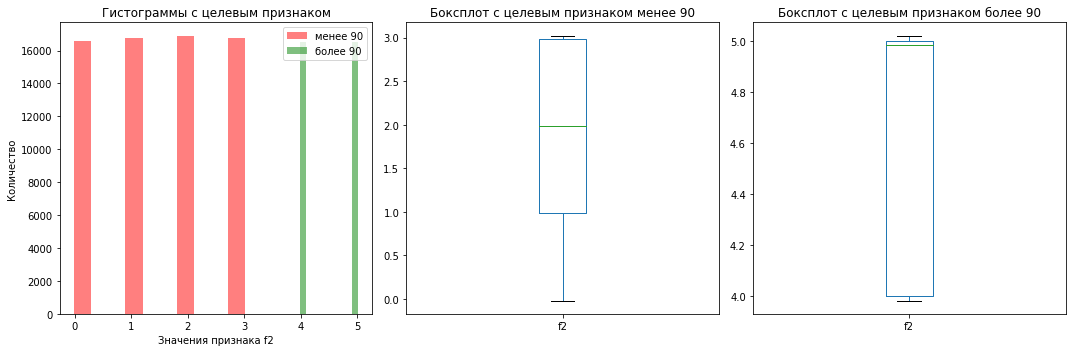

In [23]:
research_numeric_data(analys_second_region, 'f2')
research_numeric_data_with_target(analys_second_region, 'f2', 'category_product')

Для второго региона еще интереснее. Для двух признаков их количественно больше там, где уровень добычи ниже 90. Но вот для признака `f2` получаем наинтересную картину - добыча выше 90 только когда значение признака равно или выше 4.

Описание данных:


count    100000.000000
mean          0.002023
std           1.732045
min          -8.760004
25%          -1.162288
50%           0.009424
75%           1.158535
max           7.238262
Name: f0, dtype: float64


Уникальные значения(10 наиболее частых):


 1.936057    1
-0.784222    1
-2.351132    1
 0.075698    1
 2.018140    1
 1.568685    1
 0.817402    1
-3.875972    1
 4.784885    1
-1.397090    1
Name: f0, dtype: int64

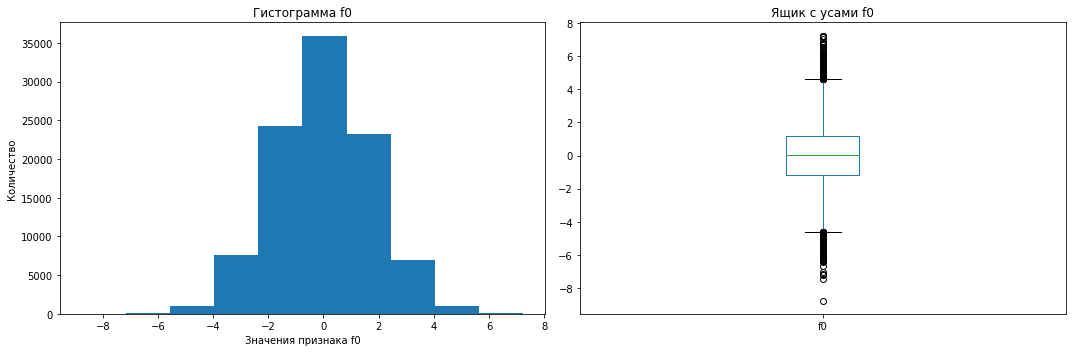

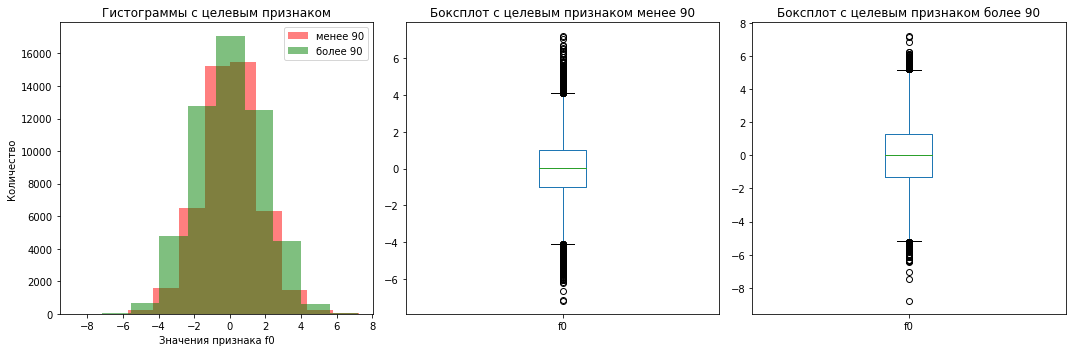

In [24]:
research_numeric_data(analys_third_region, 'f0')
research_numeric_data_with_target(analys_third_region, 'f0', 'category_product')

Описание данных:


count    100000.000000
mean         -0.002081
std           1.730417
min          -7.084020
25%          -1.174820
50%          -0.009482
75%           1.163678
max           7.844801
Name: f1, dtype: float64


Уникальные значения(10 наиболее частых):


-0.424195    1
 0.182324    1
 0.577029    1
 0.162839    1
 1.018798    1
-0.982400    1
-0.553582    1
 0.463661    1
 1.333593    1
 0.198899    1
Name: f1, dtype: int64

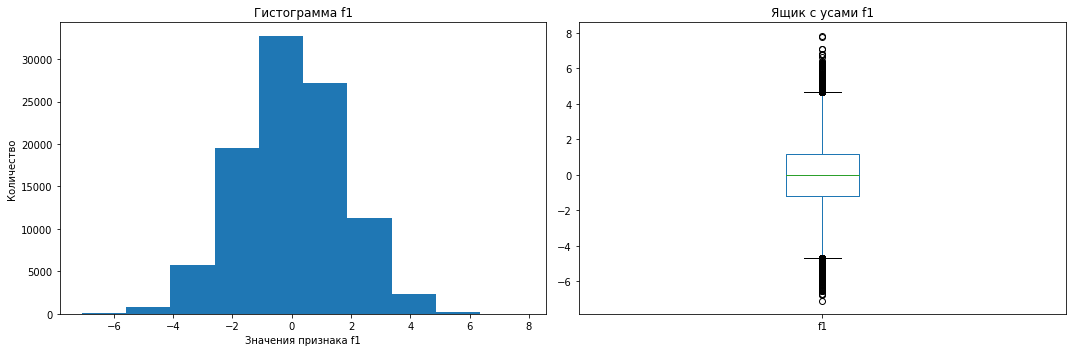

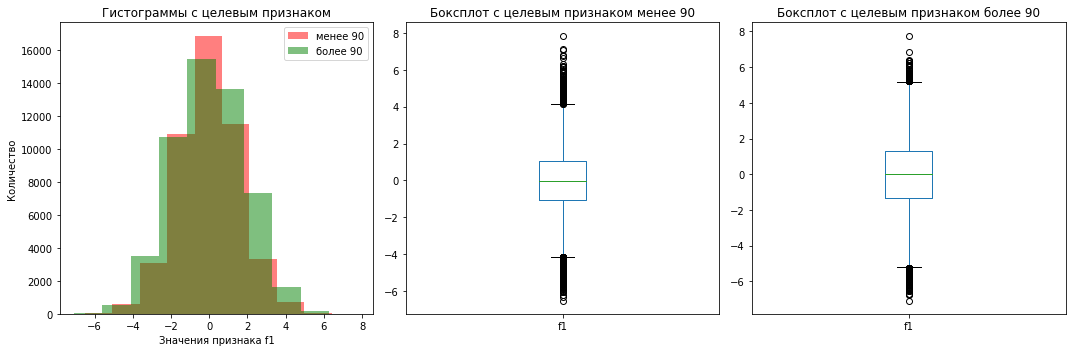

In [25]:
research_numeric_data(analys_third_region, 'f1')
research_numeric_data_with_target(analys_third_region, 'f1', 'category_product')

Описание данных:


count    100000.000000
mean          2.495128
std           3.473445
min         -11.970335
25%           0.130359
50%           2.484236
75%           4.858794
max          16.739402
Name: f2, dtype: float64


Уникальные значения(10 наиболее частых):


 1.553554     1
 1.549816     1
 10.578156    1
 1.456220     1
 8.867106     1
 6.954979     1
 3.783642     1
 2.374247     1
 2.521911     1
-5.108304     1
Name: f2, dtype: int64

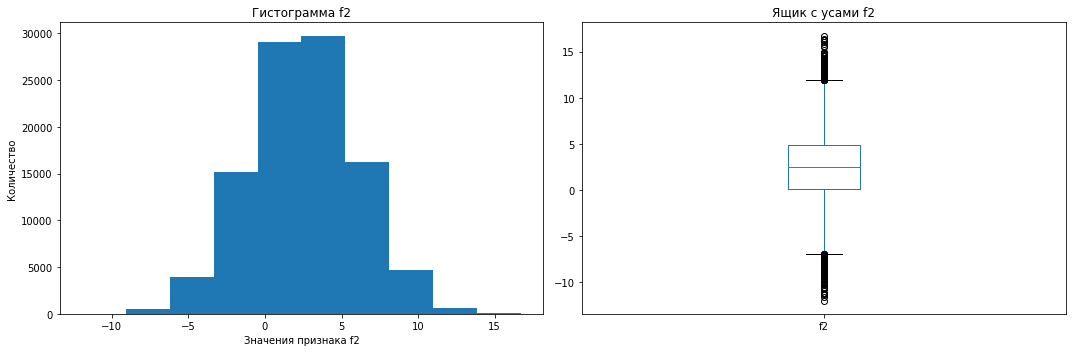

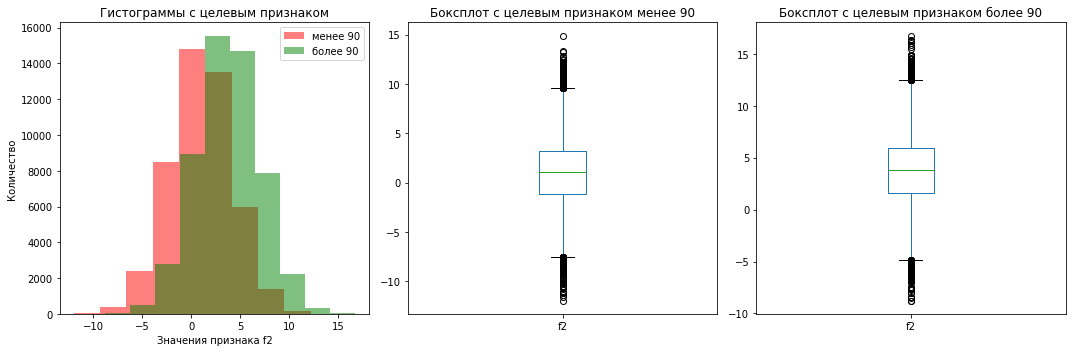

In [26]:
research_numeric_data(analys_third_region, 'f2')
research_numeric_data_with_target(analys_third_region, 'f2', 'category_product')

Распределение данных в третьем регионе примерно такое же, как и в первом. Запасы тем больше, чем больше признак `f2`.

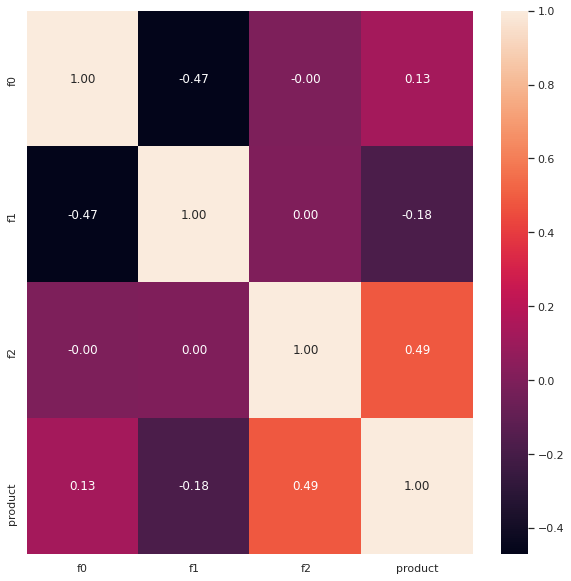

In [27]:
sns.set(rc={"figure.figsize": (10, 10)})
sns.heatmap(data_first_region.drop(['id'], axis=1).corr(method='spearman'), annot=True, fmt='.2f');

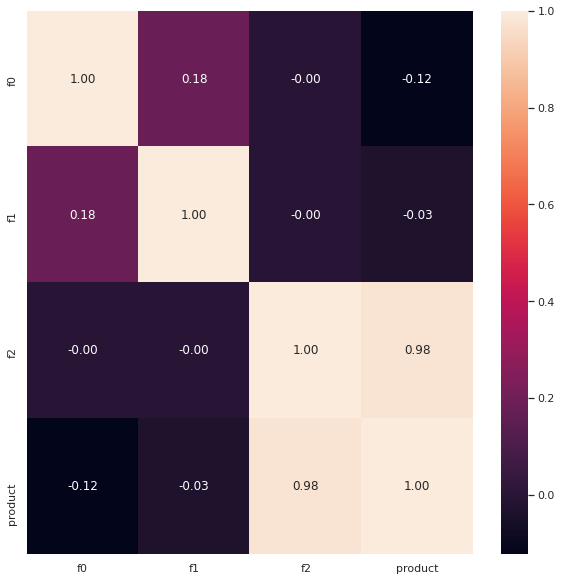

In [28]:
sns.heatmap(data_second_region.drop(['id'], axis=1).corr(method='spearman'), annot=True, fmt='.2f');

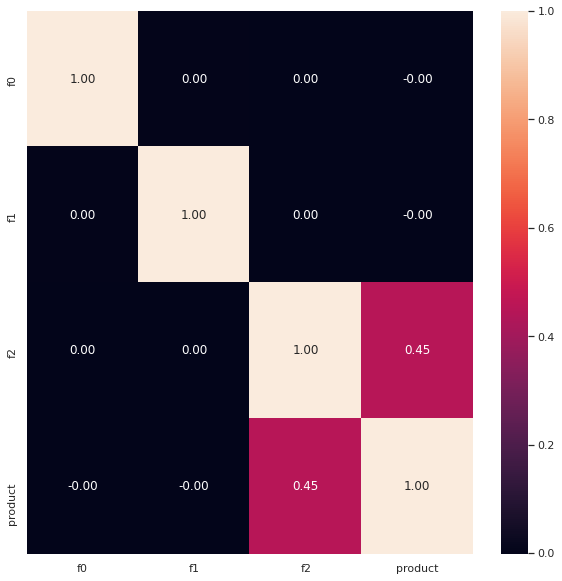

In [29]:
sns.heatmap(data_third_region.drop(['id'], axis=1).corr(method='spearman'), annot=True, fmt='.2f');

Имеем сильную корреляционную зависимость целевого признака с признаком `f2` из второго региона. Удалять его конечно не будем, учитывая, что не знаем про этот признак ничего, кроме того, что он важный, но отметить стоит.

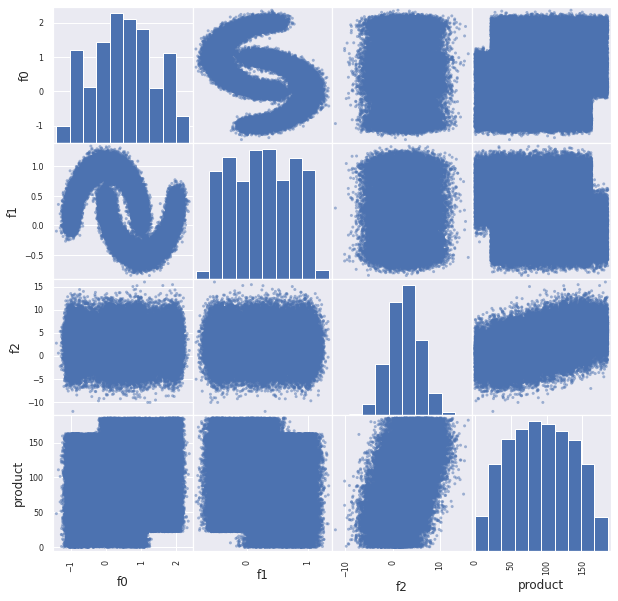

In [30]:
pd.plotting.scatter_matrix(data_first_region.drop(['id'], axis=1), figsize=(10, 10));

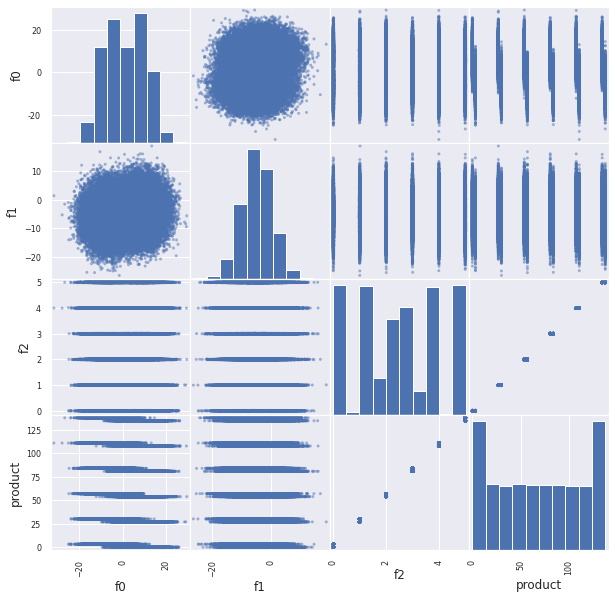

In [31]:
pd.plotting.scatter_matrix(data_second_region.drop(['id'], axis=1), figsize=(10, 10));

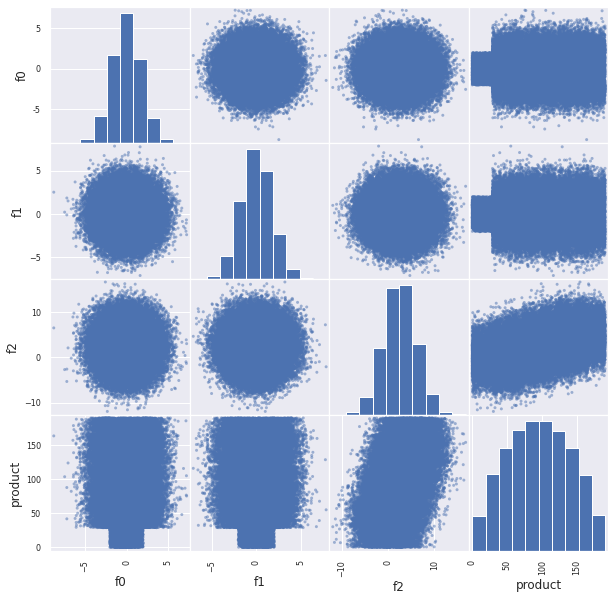

In [32]:
pd.plotting.scatter_matrix(data_third_region.drop(['id'], axis=1), figsize=(10, 10));

Довольно занятная визуалиция, явно видим линейную зависимость одного из признаков с целевым во втором регионе, а два серпа в первом регионе для признака `f1` тоже выглядят внушительно. Интересно, это такая пасхалка для студентов, что используют диаграмы рассеяния или просто совпадение?!

## Обучение и проверка модели

Перед обучением модели зададим константы, подготовим данные и разобьем их в необходимом соотношении 75:25 для обучающей и валидационной выборки, используя общие функции. В теории речь шла про разбитие на блоки через кросс-валидацию, но в самом задании про это не слова. Значит это дополнительный теоретический бонус и мы навсегда запомним тот момент, когда на курсе по DS теории оказалось больше, чем требуется для выполнения проекта :D Простите, не удержался, просто последние два проекта прям ппц в этом плане. Если нужно будет, то я могу и переписать под кросс-валидацию. В первом проекте по линейным машинкам я использовал свой класс, поэтому здесь использую то же самое.

In [33]:
class ProjectLinModel:
    """Класс для оптимизации кода обучения модели."""
    def __init__(self, X, y, RANDOM_STATE=4221, TEST_SIZE=0.25):
        self.RANDOM_STATE = RANDOM_STATE
        self.TEST_SIZE = TEST_SIZE
        self.X = X
        self.y = y
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.cat_col_names = None
        self.num_col_names = None
        self.model_lr = None
        self.predictions = None
        self.residuals = None
        self.encoder = None
        self.scaler = None
        
    def selections_for_two_groups(self):
        """Разделяет выборки на тренировочную и тестовую."""
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X,
            self.y,
            random_state=self.RANDOM_STATE,
            test_size=self.TEST_SIZE
        )
        print(self.X_train.shape, self.X_test.shape, self.y_train.shape, self.y_test.shape, sep='\n')
        return self

    def create_num_and_cat_col(self):
        """По переданному X обновляет наименование колонок для числовых и категориальных данных."""
        self.cat_col_names = self.X.select_dtypes(['object']).columns.to_list()
        print('cat_col_names =', self.cat_col_names)
        self.num_col_names = self.X.select_dtypes(exclude=['object']).columns.to_list()
        print('num_col_names =', self.num_col_names)

    def scaler_and_encoder(self):
        """Масштабирует числовые признаки, и кодирует категориальные."""
        # Кодируем кодируемые данные, масштабируем масштабируемые.
        scaler = StandardScaler()
        
        # Кодировать нечего, все признаки числовые.
        #encoder = OneHotEncoder(drop='first', sparse=False)
        #X_train_ohe = encoder.fit_transform(self.X_train[self.cat_col_names])
        #X_test_ohe = encoder.transform(self.X_test[self.cat_col_names])
        #encoder_col_names = encoder.get_feature_names()
        
        self.num_col_names = self.X.select_dtypes(exclude=['object']).columns.to_list()
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(self.X_train[self.num_col_names])
        X_test_scaled = scaler.transform(self.X_test[self.num_col_names])
        
        # создаём тренировочный и тестовый датафреймы из закодированных и отмасштабированных данных
        #X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
        #X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

        X_train_scaled = pd.DataFrame(X_train_scaled, columns=self.num_col_names)
        X_test_scaled = pd.DataFrame(X_test_scaled, columns=self.num_col_names)

        # объединяем все преобразованные данные в тренировочный и тестовый датафреймы
        # сбрасываем индексы в датафрейме с числовыми индексами, чтобы избежать ошибок
        #self.encoder = encoder
        self.scaler = scaler
        #self.X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
        #self.X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)
        self.X_train = X_train_scaled
        self.X_test = X_test_scaled

    def create_and_fit_model(self):
        """Создаём и обучаем модель линейной регрессии."""
        # Создали модель линейной регрессии
        self.model_lr = LinearRegression(n_jobs=-1)

        # Обучили её на данных
        self.model_lr.fit(self.X_train, self.y_train)
        return self
    
    def predict_model(self, data=None, train=True):
        """Предсказывает целевой признак и возвращает предсказания, если не обучающая выборка."""
        # Предсказываем целевой признак
        if train:
            data = self.X_test
            self.predictions = self.model_lr.predict(data)
            return self
        else:
            return self.model_lr.predict(data)

    def metrics_rmse(self):
        """Определяет корень среднеквадратичной ошибки(rmse)."""
        rmse = mean_squared_error(self.y_test, self.predictions, squared=False)
        print("RMSE LinearRegression =", rmse)

    def visual_residuals(self):
        """Рассчитывает остатки и строит графики."""
        self.residuals = self.y_test - self.predictions

        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
        axes[0].hist(self.residuals)
        axes[0].set_title('Гистограмма распределения остатков')
        axes[0].set_xlabel('Остатки')

        axes[1].scatter(self.predictions, self.residuals)
        axes[1].set_xlabel('Предсказания модели')
        axes[1].set_ylabel('Остатки')
        axes[1].set_title('Анализ дисперсии')
        plt.show()

In [34]:
def predictions_and_metrics(data, random_state=4221, test_size=0.25):
    """
    Принимает на вход врейм данных, разбивает его на тренировочное и валидационную выборки,
    обучает модель, сохраняет предсказания, рассчитывает метрику.
    Поскольку задача не тривиальная, то считаю уместным такое количество логики в одной функции.
    """
    features = data.drop(['id', 'product'], axis=1)
    target = data['product']
    
    model_lr = ProjectLinModel(features, target)
    model_lr.selections_for_two_groups().create_num_and_cat_col()
    model_lr.scaler_and_encoder()
    
    predictions = model_lr.create_and_fit_model().predict_model()
    correct_anwser = model_lr.y_test
    
    print('Средний запас предсказанного сырья:', round(predictions.predictions.mean(), 2), 'тыс. баррелей')
    model_lr.metrics_rmse()
    model_lr.visual_residuals()
    
    return predictions, correct_anwser

Проведем расчеты и обучение модели для первого региона. В задании этого не требуется, но можно так же переписать немного код, чтобы функция возвращала модель, если это потребуется.

(75000, 3)
(25000, 3)
(75000,)
(25000,)
cat_col_names = []
num_col_names = ['f0', 'f1', 'f2']
Средний запас предсказанного сырья: 92.57 тыс. баррелей
RMSE LinearRegression = 37.79536808017317


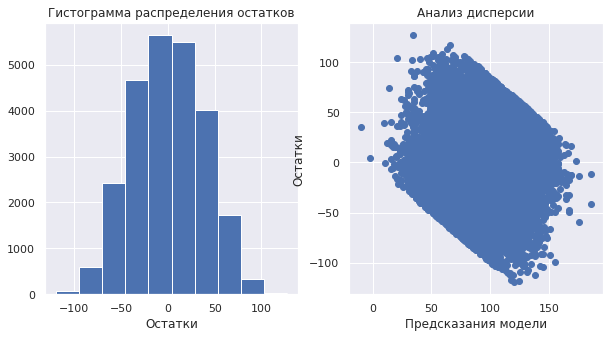

Истинный средний запас сырья в регионе 92.7 тыс. баррелей


In [35]:
pred_1, y_valid_1 = predictions_and_metrics(data_first_region)
print('Истинный средний запас сырья в регионе', round(y_valid_1.mean(), 2), 'тыс. баррелей')

Понимаю, что и про остатки в задании не говорили и это не требовалось, но же ранее написал класс для такого типа моделей, то почему бы и не переиспользовать эти моменты.   
Гистограмма распределения остатков в целом равномерна, визуально смещений я не вижу. Дисперсия в целом распределена равномерно, но как бы с двумя границами.    
     
Предсказания модели практически совпадают с истинными запасами.

(75000, 3)
(25000, 3)
(75000,)
(25000,)
cat_col_names = []
num_col_names = ['f0', 'f1', 'f2']
Средний запас предсказанного сырья: 68.8 тыс. баррелей
RMSE LinearRegression = 0.8904248837272424


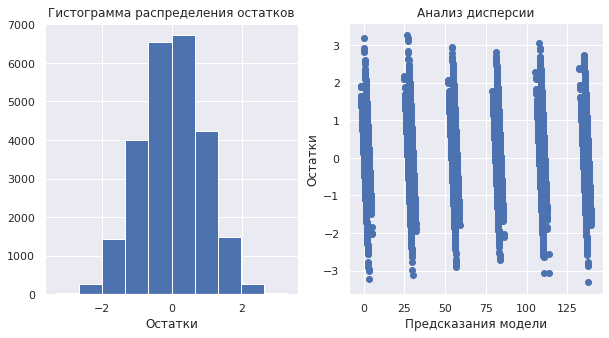

Истинный средний запас сырья в регионе 68.8 тыс. баррелей


In [36]:
pred_2, y_valid_2 = predictions_and_metrics(data_second_region)
print('Истинный средний запас сырья в регионе', round(y_valid_2.mean(), 2), 'тыс. баррелей')

Для второго региона видим довольно странное распределение дисперсии, что скорее всего говорит о том, что какой-то категориальный признак был закодирован в число. В целом так же предсказания совпадают практически с реальными значениями и очень низкая средняя квадратичная ошибка.

(75000, 3)
(25000, 3)
(75000,)
(25000,)
cat_col_names = []
num_col_names = ['f0', 'f1', 'f2']
Средний запас предсказанного сырья: 95.24 тыс. баррелей
RMSE LinearRegression = 40.09419604130936


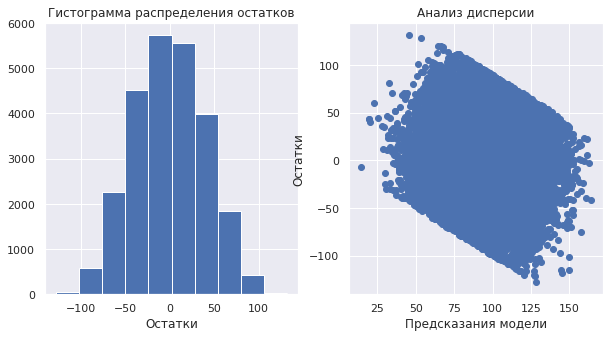

Истинный средний запас сырья в регионе 94.56 тыс. баррелей


In [37]:
pred_3, y_valid_3 = predictions_and_metrics(data_third_region)
print('Истинный средний запас сырья в регионе', round(y_valid_3.mean(), 2), 'тыс. баррелей')

**Вывод:**   
* Модель для второго региона показала лучший результат по точнорсти предсказания и величине средней квадратичной ошибки, и в исследовательском анализе мы предположили почему, да и по анализу дисперсии так же это заметно.
* Наиболее богатые по запасам регионы: первый и третий.

## Подготовка к расчёту прибыли

Ключевые значения для расчётов сохраним в отдельных переменных.

In [38]:
class DataProfit:
    """
    Класс для хранения данных при расчете.
    Увидел на ютубе такую штуку по оптимизации функций в лице классов для хранения данных.
    Иначе нам по 5-7 переменных передавать в функцию - проще передать класс, чтобы данные не хранились
    в главной области видимости.
    """
    POINTS = 500  # при разведке региона исследуют 500 точек
    BEST_POINTS = 200  # с помощью машинного обучения выбирают 200 лучших для разработки
    BUDGET = 10 * (10**9)  # бюджет на разработку скважин в регионе
    INCOME_PER_UNIT = 450000  # доход с каждой единицы продукта составляет
    PROBABILITY_OF_LOSSES = 2.5  # после оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2,5 %

Поскольку нам нужно найти необходимый объем сырья, то мы можем взять бюджет на разработку в регионе и размелить его на произведение 200 лучших точек для разработки и дохода с каждой единицы продукта.

In [39]:
sufficient_amount = DataProfit.BUDGET / (DataProfit.BEST_POINTS * DataProfit.INCOME_PER_UNIT)
print('Достаточный объём сырья для безубыточной разработки новой скважины:', round(sufficient_amount, 2), 'тыс.баррелей')

Достаточный объём сырья для безубыточной разработки новой скважины: 111.11 тыс.баррелей


**Вывод:** ни один из трех исследуемых регионов по предварительному расчету, не является безубыточным, поскольку ожидаемый уровень запасов сырья меньше необходимого для безубыточной разработки.

## Расчёт прибыли и рисков 

In [40]:
def profit(data, probalities, region_number, DataProfit=DataProfit):
    """Расчет прибыли регионов исходя из выбора 200 лучших точек."""
    probalities_best = probalities.sort_values(ascending=False)
    top_probalities = data[probalities_best.index][:DataProfit.BEST_POINTS]
    return DataProfit.INCOME_PER_UNIT * top_probalities.sum() - DataProfit.BUDGET

Рассчитаем прибыль для полученного объёма сырья и исходя из 200 лучших по запасам точкам:

In [41]:
y_region_1 = y_valid_1.reset_index(drop=True)
y_region_2 = y_valid_2.reset_index(drop=True)
y_region_3 = y_valid_3.reset_index(drop=True)

# Для визуального удобства, как привыкли экономисты - прибыль учтем в миллионах
print('Прибыль региона №1:', round(profit(y_region_1, pd.Series(pred_1.predictions), 200) / 10**6, 2), 'млн.рублей')
print('Прибыль региона №2:', round(profit(y_region_2, pd.Series(pred_2.predictions), 200) / 10**6, 2), 'млн.рублей')
print('Прибыль региона №3:', round(profit(y_region_3, pd.Series(pred_3.predictions), 200) / 10**6, 2), 'млн.рублей')

Прибыль региона №1: 3282.74 млн.рублей
Прибыль региона №2: 2415.09 млн.рублей
Прибыль региона №3: 2380.93 млн.рублей


Посчитаем риски и прибыль для каждого региона:

In [42]:
state = RandomState(4221)

def bootstrap(target, probabilities, region):
    """Функция для подсчета и вывода бутсрапа с доверительным интервалом."""
    values = []
    for i in range(1000):
        target_subsample = target.sample(n=DataProfit.POINTS, random_state=state, replace=True)
        probs_subsample = probabilities[target_subsample.index]
        values.append(profit(target_subsample, probs_subsample, 200))
        
    values = pd.Series(values)
    values_mean = values.mean()
    interval_mean = st.t.interval(0.95, len(values)-1, values.mean(), values.sem())
    risk = (values < 0).mean()
    
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    interval = (lower, upper)
        
    print(region)
    print('Средняя прибыль:', round(values_mean) / 10**6, 'млн.рублей')
    print('Доверительный интервал среднего:', interval_mean)
    
    # выводим доверительный интервал после ревью
    print('Доверительный интервал распределения прибыли:', interval)
    
    print(f'Риск:{risk:.2%}', )
    if risk*100 > DataProfit.PROBABILITY_OF_LOSSES:
        print('Вероятность убытков превышает допустимую (2,5 %) - регион не подходит для разработки')
    else:
        print('Вероятность убытков не превышает допустимую (2,5 %) - регион подходит для разработки')
    print()
    
    for_plot = values/(10**6)
    a = for_plot.plot(kind='hist', bins=30, title=f'Гистограмма рапределения прибыли {region}', xlabel='Прибыль')
    a.set_xlabel('Прибыль в млн. рублей')
    a.axvline(x=values_mean/(10**6), ymin=0, ymax=80, color='r')
    a.axvline(x=lower/(10**6), ymin=0, ymax=80, color='y')
    a.axvline(x=upper/(10**6), ymin=0, ymax=80, color='y')

<div class="alert alert-danger">
<h2> Комментарий ревьюера ❌ <a class="tocSkip"> </h2>

В задании просят найти доверительный интервал (ДИ) для распределения прибыли, в твоих расчетах ДИ для истинного среднего генеральной совокупности, это немного разные вещи (на самом деле очень разные 😁) Добавь еще расчет ДИ распределения прибыли

<div class="alert alert-info">
<h2> Комментарий студента: <a class="tocSkip"> </h2>
Аааа, точно. Теперь я понял разницу. В теории как-то прошлись по одному, в бутстрапе по второму, но как-то быстро и я не уловил этот момент. Спасибо! 

регион №1
Средняя прибыль: 494.644766 млн.рублей
Доверительный интервал среднего: (477408121.07878655, 511881411.51858944)
Доверительный интервал распределения прибыли: (-51717121.30309715, 1008634450.5988569)
Риск:3.60%
Вероятность убытков превышает допустимую (2,5 %) - регион не подходит для разработки



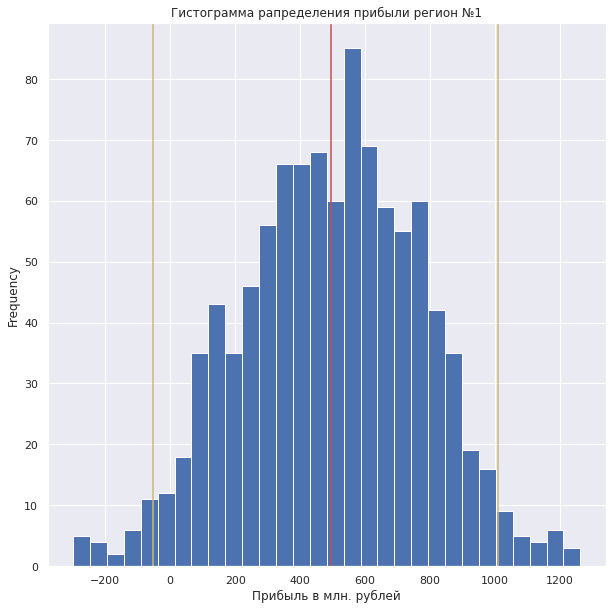

In [43]:
bootstrap(y_region_1, pd.Series(pred_1.predictions), 'регион №1')

регион №2
Средняя прибыль: 489.836347 млн.рублей
Доверительный интервал среднего: (476299950.1248357, 503372743.759302)
Доверительный интервал распределения прибыли: (59498155.51901337, 928608649.1407268)
Риск:1.50%
Вероятность убытков не превышает допустимую (2,5 %) - регион подходит для разработки



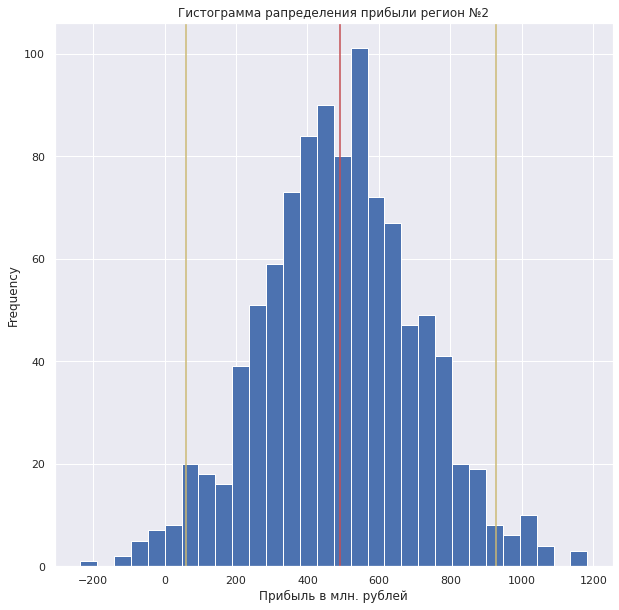

In [44]:
bootstrap(y_region_2, pd.Series(pred_2.predictions), 'регион №2')

регион №3
Средняя прибыль: 329.876472 млн.рублей
Доверительный интервал среднего: (312291505.1546318, 347461439.2344051)
Доверительный интервал распределения прибыли: (-236699744.74832428, 848598892.8010619)
Риск:12.30%
Вероятность убытков превышает допустимую (2,5 %) - регион не подходит для разработки



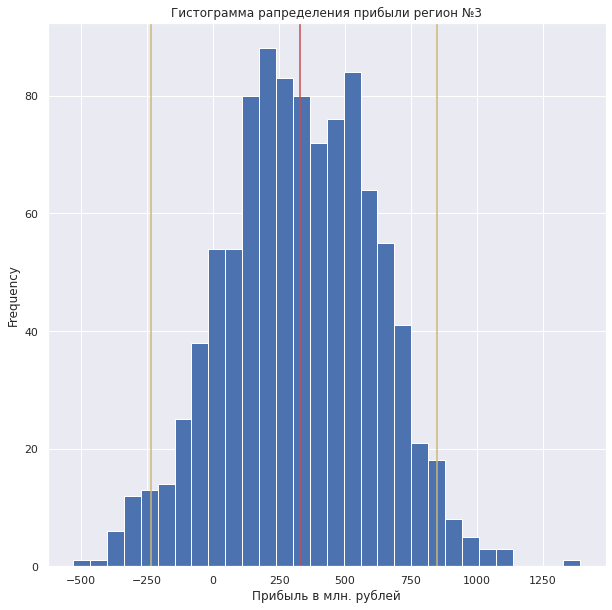

In [45]:
bootstrap(y_region_3, pd.Series(pred_3.predictions), 'регион №3')

<div class="alert alert-success">
<h2> Комментарий ревьюера ✔️ <a class="tocSkip"> </h2>

Я бы еще добавил гистограммы распределений, на которые можно вынести вертикальные линии для средних и доверительного интервала. Я бы использовал для этого [axvline](https://stackoverflow.com/questions/24988448/how-to-draw-vertical-lines-on-a-given-plot)

<div class="alert alert-info">
<h2> Комментарий студента: <a class="tocSkip"> </h2>
Реализовано.

<div class="alert alert-success">
<h2> Комментарий ревьюера v2 ✔️ <a class="tocSkip"> </h2>

Вот мое решение, вдркг что-то понравится, возьмешь на вооружение)

+------------------------+--------------------+
|       Показатель       |      Значение      |
+------------------------+--------------------+
|    Средняя выручка     |     315.8 млн      |
|          Риск          |       13.7%        |
| Доверительный интервал | -275.9 : 867.7 млн |
+------------------------+--------------------+


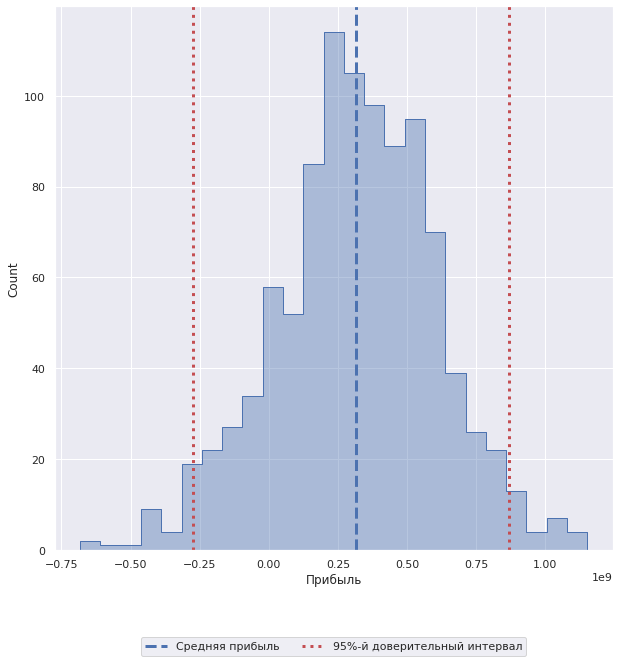

In [49]:
# !pip3 install prettytable
# from prettytable import PrettyTable
# import seaborn as sns
# from scipy import stats as st

BUDGET = 10000000000
BARREL_COST = 450
BARRELS_IN_UNIT = 1000
UNIT_COST = BARREL_COST * BARRELS_IN_UNIT
TOTAL_POINTS = 500
POINTS = 200

def revenue_2(target, predictions, points, budget, unit_cost):
    predicted_sorted = predictions.sort_values(ascending=False)
    selected = target[predicted_sorted.index][:points]
    return selected.sum() * unit_cost - budget

def bootstrap_2(target, probabilities):
    state = np.random.RandomState(888)
    values=[]
    for i in range(1000):
        target_subsample = target.sample(replace=True,\
            random_state=state, n=TOTAL_POINTS)

        probs_subsample = probabilities[target_subsample.index]
        values.append(revenue_2(target_subsample, probs_subsample, POINTS, BUDGET, UNIT_COST))

    values = pd.Series(values)
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    mean = values.mean()
    risk = st.percentileofscore(values, 0)

     # Отображение таблицы
    table = PrettyTable()
    table.field_names = ['Показатель', 'Значение']
    table.add_row(['Средняя выручка', f'{mean/1e6:.1f} млн'])
    table.add_row(['Риск', f'{risk:.3}%'])
    table.add_row(['Доверительный интервал', f'{lower/1e6:.1f} : {upper/1e6:.1f} млн'])
    print(table)

    sns.histplot(values, alpha=0.4,  element="step")
    plt.xlabel('Прибыль')
    plt.axvline(x=mean, color='b', ls='--', lw=3, label='Средняя прибыль')
    plt.axvline(x=lower, color='r', ls=':', lw=3, label='95%-й доверительный интервал')
    plt.axvline(x=upper, color='r', ls=':', lw=3)
    plt.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=2)
    plt.show()

bootstrap_2(y_region_3, pd.Series(pred_3.predictions))

Исходя из условий задачи для разработки рекомендуется регион №2, поскольку вероятность убытков не превышает значение риска по условию.

**Итоговый вывод:**    
* Проведен общий анализ данных в трех регионах и предобработка;
* Проведен исследовательский анализ в ходе которого мы выяснили: в данных одного из регионов есть сильная корреляционная зависимость между входными признаками, некоторый категориальный признак похоже закондирован в числовой;
* Обучили и проверили модель линейной регрессии. Предсказания были близки к истиному значению, остатки распределялись нормально;
* Был произведен расчет прибыли и рисков. По запасам наиболее прибыльный регион №1, с учетом рисков отвечающий условиям оказался регион №2.